In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

import spacy

2023-05-04 13:16:10.597266: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-04 13:16:10.599853: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 13:16:10.648947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 13:16:10.649557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 13:16:11.393316: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# !python3 -m spacy download fr_core_news_sm
spacy.load('fr_core_news_sm')

In [3]:
nlp = spacy.load("fr_core_news_sm")
from nltk.corpus import stopwords
from nltk import download
download('stopwords')
stopWords = set(stopwords.words('french'))
print(stopWords)

{'étais', 'soyez', 'soyons', 'son', 'te', 'nous', 'as', 'ayants', 'qui', 'ayant', 'avait', 'serions', 'étions', 'aviez', 'ayons', 'que', 'fusse', 'fut', 'ait', 't', 'étant', 'étantes', 'ou', 'nos', 'par', 'y', 'soient', 'tes', 'eussent', 'ne', 'fus', 'sur', 'seriez', 'étées', 'eussions', 'qu', 'aies', 'était', 'et', 'eut', 'ont', 'eûmes', 'eues', 'ton', 'le', 'ce', 'mes', 'eusses', 'ta', 'seront', 'étante', 'lui', 'es', 'sa', 'avais', 'notre', 'fussiez', 'du', 'étiez', 'eux', 'eu', 'aient', 'avions', 'une', 'eût', 'étés', 'l', 'vous', 'de', 'sommes', 'serait', 'ayantes', 'tu', 'sont', 'il', 'ces', 'c', 'ma', 'moi', 'serez', 'un', 'furent', 'des', 'auraient', 'on', 'avec', 'd', 'serai', 'soit', 'ai', 'eurent', 'êtes', 'vos', 'eusse', 'sera', 'est', 'avaient', 'aurez', 'à', 'm', 'avez', 'n', 'eus', 'aurai', 'se', 's', 'suis', 'fûmes', 'aurais', 'auras', 'ayante', 'aux', 'fussent', 'dans', 'fussions', 'aie', 'fusses', 'mais', 'toi', 'seras', 'aurions', 'ils', 'auriez', 'serons', 'eûtes', 

[nltk_data] Downloading package stopwords to /home/el0h1m/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# BILSTM

## Chargement des Données

In [4]:
# Données d'entrainement
train_data_complete = pd.read_csv("../data/allocine_genres_train.csv", sep=",")
train_data = train_data_complete[["titre", "synopsis", "genre"]]

# Données de test/validation
test_data_complete = pd.read_csv("../data/allocine_genres_test.csv", sep=",")
test_data = test_data_complete[["titre", "synopsis", "genre"]]

In [5]:
import string

def preprocess(sentence) :
    list_w = nlp(sentence)
    list_w_clean = []
    res = []
    for token in list_w:
        if (token.text.lower() not in stopWords) and (token.text not in string.punctuation):
            list_w_clean.append(token)
    for token in list_w_clean:
        res.append(token.lemma_.lower())
    return " ".join(res)

In [6]:
X = train_data.drop('genre', axis=1)
y = train_data['genre']

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)
#ros = RandomUnderSampler(random_state=42)

X["titre"] = X["titre"].apply(preprocess)
X["synopsis"] = X["synopsis"].apply(preprocess)

# Perform oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Convert the resampled data back to a DataFrame
train_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='genre')], axis=1)

Lister les classes et leur associer un identifiant unique. (Utile pour le plongement des mots et pour l'entraînement du CNN).

In [7]:
# Liste des genres
genre_name = sorted(train_data.genre.unique().flatten())
print("Genres:", genre_name)
print("Nombre d'exemplaires:", len(train_data))

# Identifiant unique par genre
genre_index = {genre_name[i]:i for i in range(len(genre_name))}
genre_index

Genres: ['biopic', 'comédie', 'documentaire', 'drame', 'historique', 'horreur', 'policier', 'romance', 'science fiction']
Nombre d'exemplaires: 4509


{'biopic': 0,
 'comédie': 1,
 'documentaire': 2,
 'drame': 3,
 'historique': 4,
 'horreur': 5,
 'policier': 6,
 'romance': 7,
 'science fiction': 8}

Remplacer les genres par la valeur numérique associée.

In [8]:
train_data = train_data.replace({"genre": genre_index})
train_data.head()

,titre,synopsis,genre
0,crime orient express,visite istanbul célèbre détectiv belge hercule...,6
1,12 homme colère,jeune homme origine modeste accuser meurtre pè...,3
2,après bonheur,lorsque marie-laure mère quatre jeune enfant a...,3
3,lumière ville,vagabond ’ éprendre ’ belle jeune vendeur fleu...,7
4,chemin dignité,histoire vrai carl brashear premier afro améri...,0


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data[["titre", "synopsis"]],
                                                    train_data[["genre"]],
                                                    test_size=0.001,
                                                    random_state=12, # Random seed for shuffle
                                                    shuffle=True)

On combine le titre et le synopsis pour pouvoir les vectoriser par la suite.

In [10]:
X_train_titre = X_train.titre
X_train = X_train_titre + " " + X_train.synopsis

In [11]:
X_train.head()

841     mourir 20 an soudan province ’ aljazira jour p...
2949    tina histoire anna mae bullock promettre humbl...
868     fleur tonnerre 1800 bretagne genou accabler ré...
1284    prof 2 pire prof france débarquer angleterre m...
1267    char olivier autre histoire palestine histoire...
dtype: object

In [12]:
y_train.head()

,genre
841,3
2949,0
868,3
1284,1
1267,2


In [13]:
print(X_train.shape)
print(y_train.shape)

(4504,)
(4504, 1)


## Indexation du Vocabulaire

In [14]:
def get_vectorizer(documents, max_voc_size=8000, max_seq_length= 200, batch_size=64):
	vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_voc_size, output_sequence_length=max_seq_length)
	# Création du jeu de données à partir de X_train et constitution de lots de 128 instances
	text_ds = tf.data.Dataset.from_tensor_slices(documents).batch(batch_size)
	# Création du vocabulaire à partir des données d'entrée
	vectorizer.adapt(text_ds)
	return vectorizer

In [15]:
vectorizer = get_vectorizer(X_train)

2023-05-04 13:17:00.464918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4504]
	 [[{{node Placeholder/_0}}]]


In [16]:
voc = vectorizer.get_vocabulary()
print(len(voc))

8000


In [17]:
voc[:10]

['', '[UNK]', '’', 'avoir', 'plus', 'tout', 'faire', 'aller', 'vie', 'jeune']

In [18]:
word_index = dict(zip(voc, range(len(voc))))

In [19]:
print("Texte initial:", X_train.iloc[1])
output = vectorizer([X_train.iloc[1]])
print("Vocabulaire dans le texte (15 premiers items):")
for v in output.numpy()[0, :15]:
    print(v, vectorizer.get_vocabulary()[v])

Texte initial: tina histoire anna mae bullock promettre humble carrièr infirmier après rencontre ike turner vie orageux aller devenir grand chanteur rock conner
Vocabulaire dans le texte (15 premiers items):
1 [UNK]
23 histoire
861 anna
5329 mae
1 [UNK]
680 promettre
1 [UNK]
1 [UNK]
1519 infirmier
33 après
66 rencontre
1 [UNK]
6831 turner
8 vie
5260 orageux


## Chargement de Plongements de Mots Pré-entraînés

In [20]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("../embedding/frWiki_no_phrase_no_postag_700_cbow_cut100.bin", binary=True, unicode_errors="ignore")
model.most_similar("bonjour")

[('merci', 0.7507892847061157),
 ('bonsoir', 0.7450243830680847),
 ('votre', 0.5642200112342834),
 ('vous', 0.5538792014122009),
 ('remercier', 0.5396129488945007),
 ('avance', 0.5288880467414856),
 ('discuter', 0.5033395886421204),
 ('je', 0.49339333176612854),
 ('désoler', 0.4899965822696686),
 ('ici', 0.4887441396713257)]

In [21]:
model.key_to_index

{'</s>': 0,
 'de': 1,
 'la': 2,
 'à': 3,
 'le': 4,
 'et': 5,
 'être': 6,
 'en': 7,
 'les': 8,
 'un': 9,
 'une': 10,
 'avoir': 11,
 'il': 12,
 'dans': 13,
 'par': 14,
 'catégorie': 15,
 'pour': 16,
 'sur': 17,
 'que': 18,
 'se': 19,
 'qui': 20,
 'des': 21,
 'ce': 22,
 'avec': 23,
 'ne': 24,
 'son': 25,
 'an': 26,
 'plus': 27,
 'ou': 28,
 'pas': 29,
 'faire': 30,
 'elle': 31,
 'sa': 32,
 'pouvoir': 33,
 'pop': 34,
 'premier': 35,
 'mais': 36,
 'comme': 37,
 'cette': 38,
 'français': 39,
 'avancement': 40,
 'ses': 41,
 'je': 42,
 'on': 43,
 'deux': 44,
 'france': 45,
 'tout': 46,
 'aussi': 47,
 'lien': 48,
 'grand': 49,
 'année': 50,
 'autre': 51,
 'naissance': 52,
 'article': 53,
 'nom': 54,
 'après': 55,
 'voir': 56,
 'commune': 57,
 'état': 58,
 'ville': 59,
 'externe': 60,
 'y': 61,
 'paris': 62,
 'référence': 63,
 'entre': 64,
 'lui': 65,
 'même': 66,
 'source': 67,
 'sous': 68,
 'jean': 69,
 'lieu': 70,
 'leur': 71,
 'site': 72,
 'note': 73,
 'où': 74,
 'dont': 75,
 'film': 76,
 'ce

In [22]:
model["bonjour"]

array([-4.67579126e-01, -9.34297621e-01, -3.89060646e-01, -2.03962207e-01,
        6.24373436e-01,  5.58501959e-01, -7.94236243e-01,  9.47133780e-01,
       -7.85477459e-01, -4.23343748e-01, -3.78552794e-01,  9.85341787e-01,
       -9.94831264e-01,  7.94630885e-01, -3.72711942e-02, -1.31745422e+00,
       -2.15552300e-01, -1.77847058e-01,  4.44615424e-01,  2.40859807e-01,
       -1.34950832e-01,  2.62641966e-01,  7.27709755e-02, -4.39429581e-01,
        3.13311636e-01,  4.89237309e-01, -3.47837150e-01,  6.98559701e-01,
        3.06835920e-01,  8.79080057e-01, -5.81417084e-01, -3.37294281e-01,
        1.81973651e-01,  7.02408612e-01,  7.81347573e-01,  5.16828001e-01,
        2.21238777e-01, -4.01979834e-01, -3.04546077e-02,  5.94205201e-01,
        7.80208051e-01, -4.02492434e-01,  1.09107220e+00,  1.95819825e-01,
        1.20070234e-01,  4.59087253e-01,  6.24428272e-01,  3.55202556e-02,
       -1.29575109e+00, -5.80421746e-01,  4.97552425e-01,  3.83994550e-01,
       -6.25843883e-01,  

Le plongement pré-entrainé est de dimension 700.

In [23]:
len(model["bonjour"])

700

In [24]:
def load_embeddings(embeddings_model):
    embeddings_index = {}
    for word in list(embeddings_model.key_to_index.keys()):
        embeddings_index[word] = embeddings_model[word]
    print(f'{len(embeddings_index)} vecteurs de mots ont été lus')
    return embeddings_index

In [25]:
embeddings = load_embeddings(model)

39392 vecteurs de mots ont été lus


La cellule suivante permet de créer une matrice de plongements: une matrice où la ligne i correspond au plongement pré-entraîné pour le mot d'indice i dans le vocabulaire.

In [26]:
def get_embedding_matrix(vocabulary, embeddings_index, embedding_dim = 700):
  num_tokens = len(vocabulary)
  hits = 0
  misses = 0

  # Préparation de la matrice
  # Les mots qui ne se trouvent pas dans les plongements pré-entraînés seront 
  # représentés par des vecteurs dont toutes les composantes sont égales à 0,
  # y compris la représentation utilisée pour compléter les documents courts et
  # celle utilisée pour les mots inconnus [UNK]
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print(f'{hits} mots ont été trouvés dans les plongements pré-entraînés')
  print(f'{misses} sont absents')
  return embedding_matrix

In [27]:
# Construction de la matrice de plongements à partir du vocabulaire
embedding_matrix = get_embedding_matrix(voc, embeddings)

6068 mots ont été trouvés dans les plongements pré-entraînés
1932 sont absents


## Construction du LSTM

In [28]:
from tensorflow.keras.layers import Embedding

def get_biLSTM_model(voc_size, embedding_matrix, embedding_dim=700):
  # Création du modèle
  int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
  embedding_layer = Embedding(voc_size, embedding_dim, trainable=True,
      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
  )
  
  embedded_sequences = embedding_layer(int_sequences_input)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(embedded_sequences)
  preds = tf.keras.layers.Dense(len(genre_name), activation="softmax")(x)
  model = tf.keras.Model(int_sequences_input, preds)
  return model

In [29]:
# Affichage de l'architecture du modèle
biLSTM_model = get_biLSTM_model(len(voc), embedding_matrix)
biLSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 700)         5600000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              391680    
 l)                                                              
                                                                 
 dense (Dense)               (None, 9)                 1161      
                                                                 
Total params: 5,992,841
Trainable params: 5,992,841
Non-trainable params: 0
_________________________________________________________________


## Entraînement du LSTM

In [30]:
from sklearn import model_selection
from tensorflow.keras.callbacks import EarlyStopping # Early stopping to avoid over-fitting

# Fonction pour l'entraînement d'un modèle
def train_model(X, y, model_function, vectorizer, voc_size, embedding_matrix, embedding_dim=700, batch_size=64): # 128
    
    # Early stopping callback
    early_stopping_callback = EarlyStopping(monitor="val_acc", restore_best_weights=True, patience=3)
    
    # Listes utilisées pour sauvegarder les résultats obtenus à chaque pli
    acc_per_fold = []
    loss_per_fold = []
    histories = []
    folds = 5
    stratkfold = model_selection.StratifiedKFold(n_splits=folds, shuffle=True, random_state=12)
    fold_no = 1
    for train, test in stratkfold.split(X, y):
        m_function = globals()[model_function]
        model = m_function(voc_size, embedding_matrix, embedding_dim)

        print('------------------------------------------------------------------------')
        print(f'Entraînement pour le pli {fold_no} ...')
        fold_x_train = vectorizer(X.iloc[train].to_numpy()).numpy()
        fold_x_val = vectorizer(X.iloc[test].to_numpy()).numpy()
        fold_y_train = y.iloc[train].to_numpy()
        fold_y_val = y.iloc[test].to_numpy()

        # Compilation du modèle : permet de préciser la fonction de perte et l'optimiseur
        # loss=sparse_categorical_crossentropy : entropie croisée, dans le cas où les 
        # classes cibles sont indiquées sous forme d'entiers. Il s'agira de minimiser
        # la perte pendant l'apprentissage
        # optimizer=rmsprop : l'optimiseur détermine la manière doit les poids seront
        # mis à jour pendant l'apprentissage
        model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])
        # Entraînement sur 10 époque (la totalité du jeu de données est parcourue
        # 10 fois)
        history = model.fit(fold_x_train, fold_y_train, batch_size=batch_size, epochs=25, validation_data=(fold_x_val, fold_y_val), callbacks=[early_stopping_callback])
        histories.append(history)
        # Evaluation sur les données de validation
        scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
        print(f'Scores pour le pli {fold_no}: {model.metrics_names[0]} = {scores[0]:.2f};',
            f'{model.metrics_names[1]} = {scores[1]*100:.2f}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        fold_no = fold_no + 1

    # Affichage des scores moyens par pli
    print('---------------------------------------------------------------------')
    print('Scores par pli')
    for i in range(0, len(acc_per_fold)):
        print('---------------------------------------------------------------------')
        print(f'> Pli {i+1} - Loss: {loss_per_fold[i]:.2f}', f'- Accuracy: {acc_per_fold[i]:.2f}%')
    print('---------------------------------------------------------------------')
    print('Scores moyens pour tous les plis :')
    print(f'> Accuracy: {np.mean(acc_per_fold):.2f}', f'(+- {np.std(acc_per_fold):.2f})')
    print(f'> Loss: {np.mean(loss_per_fold):.2f}')
    print('---------------------------------------------------------------------')
    return histories

In [31]:
# Entraînement du modèle et récupération des résultats
biLSTM_histories = train_model(X_train, y_train, 'get_biLSTM_model', vectorizer, len(voc), embedding_matrix)

------------------------------------------------------------------------
Entraînement pour le pli 1 ...
Epoch 1/25
57/57 [==============================] - 33s 540ms/step - loss: 1.9065 - acc: 0.3708 - val_loss: 1.5142 - val_acc: 0.5194
Epoch 2/25
57/57 [==============================] - 31s 546ms/step - loss: 1.2567 - acc: 0.6181 - val_loss: 1.2230 - val_acc: 0.5794
Epoch 3/25
57/57 [==============================] - 31s 546ms/step - loss: 0.9026 - acc: 0.7250 - val_loss: 1.1025 - val_acc: 0.6404
Epoch 4/25
57/57 [==============================] - 31s 549ms/step - loss: 0.6729 - acc: 0.7963 - val_loss: 0.9735 - val_acc: 0.6870
Epoch 5/25
57/57 [==============================] - 31s 544ms/step - loss: 0.5254 - acc: 0.8465 - val_loss: 1.0097 - val_acc: 0.6837
Epoch 6/25
57/57 [==============================] - 31s 546ms/step - loss: 0.4083 - acc: 0.8804 - val_loss: 0.8463 - val_acc: 0.7270
Epoch 7/25
57/57 [==============================] - 34s 601ms/step - loss: 0.3019 - acc: 0.9145 - 

In [32]:
import seaborn as sns
sns.set_theme(style="darkgrid")

def plot_results(histories):
    accuracy_data = []
    loss_data = []
    for i, h in enumerate(histories):
        acc = h.history['acc']
        val_acc = h.history['val_acc']
        loss = h.history['loss']
        val_loss = h.history['val_loss']
        for j in range(len(acc)):
            accuracy_data.append([i+1, j+1, acc[j], 'Entraînement'])
            accuracy_data.append([i+1, j+1, val_acc[j], 'Validation'])
            loss_data.append([i+1, j+1, loss[j], 'Entraînement'])
            loss_data.append([i+1, j+1, val_loss[j], 'Validation'])

    acc_df = pd.DataFrame(accuracy_data, columns=['Pli', 'Epoch', 'Accuracy', 'Données'])
    sns.relplot(data=acc_df, x='Epoch', y='Accuracy', hue='Pli', style='Données', kind='line')
    
    loss_df = pd.DataFrame(loss_data, columns=['Pli', 'Epoch', 'Perte', 'Données'])
    sns.relplot(data=loss_df, x='Epoch', y='Perte', hue='Pli', style='Données', kind='line')

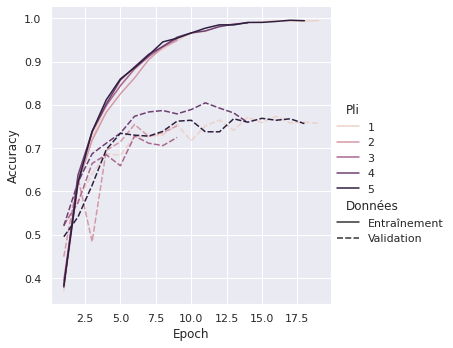

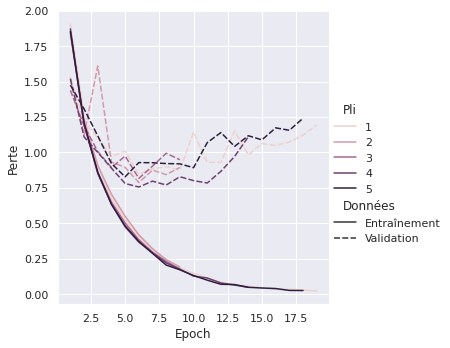

In [33]:
plot_results(biLSTM_histories)